# Проект по теме "Обучение с учителем"

## Отток клиентов банка

**Цели и задачи:**
* Проанализировать исторические данные о поведении клиентов банка, расторжении договоров. 
* Спрогнозировать уход клиента из банка.
* Построить модель классификации, метрика качества **f1** (минимальное значение **0.59**)
* Измерить **AUC-ROC**, сравнить её значение с **f1-мерой**.

**План выполнения работы:**
* Подготовка данных
  * 1.1 Загрузка данных
  * 1.2 Подготовка признаков
  * 1.3 Преобразование признака Tenure
* Исследование задачи
  * 2.1 Решающее дерево
  * 2.2 Случайный лес
  * 2.3 Логистическая регрессия
* Борьба с дисбалансом
  * 3.1 Взвешивание классов
  * 3.2 Upsampling и Downsampling
* Тестирование модели
* Общий вывод


**Описание данных:**
Исторические данные о поведении клиентов и расторжении договоров с банком.
Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Признаки**
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — количество недвижимости у клиента
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**
* `Exited` — факт ухода клиента

# 1.Изучение и подготовка данных

### 1.1 Загрузка данных

In [1]:
import pandas as pd # импорт библиотеки pandas 
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
import numpy as np # импорт библиотеки nump
from scipy import stats as st # импорт библиотеки scipy
import random


from sklearn.metrics import accuracy_score # импорт метрики из библиотеки sklearn 
from sklearn.model_selection import train_test_split # импорт разделителя
from sklearn.tree import DecisionTreeClassifier # импорт дерева решений
from sklearn.ensemble import RandomForestClassifier # импорт классификатора случайного леса
from sklearn.linear_model import LogisticRegression # импорт линейной регрессии 
from sklearn.preprocessing import StandardScaler # стандартизация
from sklearn.metrics import precision_recall_curve, classification_report # импорт метрик
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve # импорт метрик
from sklearn.utils import shuffle # импорт шаффла для перемешивания

import os
import time
from tqdm import tqdm # импорт библиотеки tqdm для просмотра прогресса обучения модели

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
#df = pd.read_csv('C:/Users/copok/Documents/Проекты/Отток клиентов/Churn.csv')

In [3]:
pth1 = 'C:/Users/copok/Documents/Проекты/Яндекс практикум/7 Отток клиентов/Churn.csv'
pth2 = '/datasets/Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df= pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
#df = pd.read_csv('/datasets/Churn.csv') Documents/Проекты/Яндекс практикум/7 Отток клиентов/Churn.csv

In [5]:
display(df.head(10))
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Из исходных данных изветсно:**
* **`RowNumber`** — индекс строки в данных
* **`CustomerId`** — уникальный идентификатор клиента
* **`Surname`** — фамилия
* **`CreditScore`** — кредитный рейтинг
* **`Geography`** — страна проживания
* **`Gender`** — пол
* **`Age`** — возраст
* **`Tenure`** — сколько лет человек является клиентом банка
* **`Balance`** — баланс на счёте
* **`NumOfProducts`** — количество продуктов банка, используемых клиентом
* **`HasCrCard`** — наличие кредитной карты
* **`IsActiveMember`** — активность клиента
* **`EstimatedSalary`** — предполагаемая зарплата
* **`Exited`** — факт ухода клиента

### 1.2 Подготовка данных 

**Изменим название колонок - отформатируем в стандартный формат:**

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df = df.rename(columns={'rownumber':'row_number', 
                        'customerid':'customer_id',  
                        'creditscore':'credit_score', 
                        'numofproducts':'num_of_products', 
                        'hascrcard':'has_crcard',
                        'isactivemember':'is_active_member', 
                        'estimatedsalary':'estimated_salary', 
                       })

In [8]:
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


* **Отбросим те столбцы, которые никак не связаны с расчетом модели машинного обучения (являются либо персональными данными пользователя, либо идентификаторами):**
  * **`row_number`** — индекс строки в данных
  * **`customer_id`** — уникальный идентификатор клиента
  * **`surname`** — фамилия

In [9]:
df = df.drop(['surname', 'row_number', 'customer_id'], axis=1)

**Проверим наличие дубликатов:**

In [10]:
df.duplicated().sum()

0

**Проверим пропущенные значения:**

In [11]:
df.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_crcard            0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

* Отсутствует **909** значений в столбце **`tenure`**, прежде, чем обучать модель, необходимо заполнить пропуски или удалить строки без значений.

**Проверим взаимосвязь наличия пропусков:**

In [12]:
df[df['tenure'].isna()]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [13]:
df['tenure'].value_counts().sort_values(ascending=False)

tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

In [14]:
df[df['tenure'].isna()]['exited'].value_counts().sort_values(ascending=False)

exited
0    726
1    183
Name: count, dtype: int64

* Выявлено: Клиенты, которые пользуются банком либо **`10 лет`**, либо **`0 лет`**, меньше, возможно, пропущенные значения - в основном у таких клиентов.

**Прежде, чем заполнять или удалять строки, проверим взаимосвязь данных:**

(-1.25, 1.25, -1.25, 1.25)

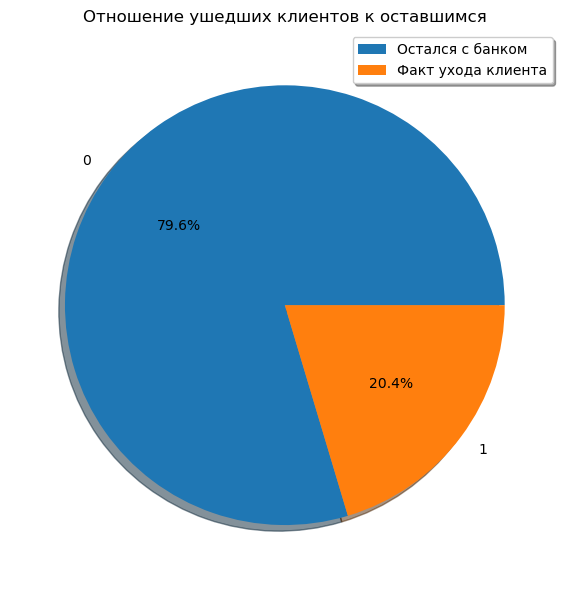

In [15]:
# Построим график с количеством людей, ушедших из банка и оставшихся
df['exited'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(6,6))
plt.legend(["Остался с банком", 'Факт ухода клиента'], fontsize= 10, shadow=True)
plt.title('Отношение ушедших клиентов к оставшимся')
plt.tight_layout()
plt.axis('off')

* Выборка несбалансирована, примерно только **20%** клиентов уходят из банка.

**Проверим корреляцию Пирсона между параметрами:**

In [16]:
df1 = df.drop(['geography', 'gender'], axis=1)

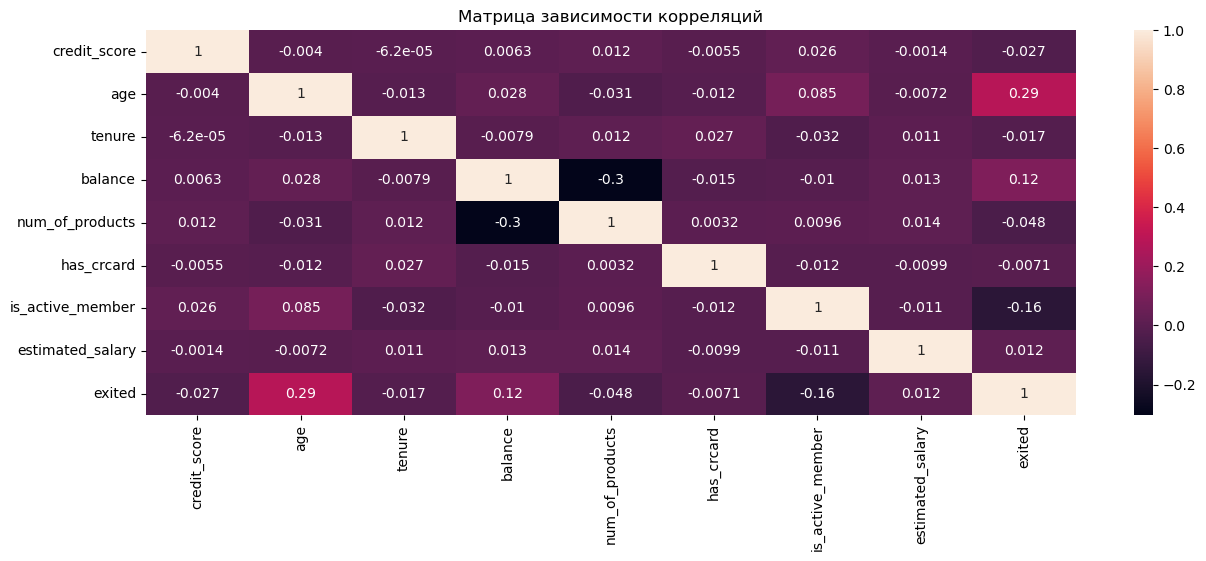

In [17]:
plt.figure(figsize=(15, 5))
plt.title('Матрица зависимости корреляций')

sns.heatmap(df1.corr(), annot = True)

plt.show()


* Больше всего коррелирует между собой параметры **`age`** и **`exited`**, но не так сильно, всего на **0,29**. Параметр возраста сильнее всего влияет на уход клиента из банка.

**Особой корреляции между остальнымит параметрами и `tenure` нет (менее 0,1), то попробуем заполнить данные медианным значением и проверим полученную корреляцию с остальными параметрами снова:**

In [18]:
# создаём новый датасет и заполняем его значениями
df_filled = df
df_filled['tenure'] = df_filled['tenure'].fillna(df_filled['tenure'].median())

In [19]:
# проверяем количество значений
df_filled['tenure'].value_counts().sort_values(ascending=False)

tenure
5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: count, dtype: int64

**Построим хитмэп коррелляции:**

In [20]:
df_filled1 = df_filled.drop(['geography', 'gender'], axis=1)

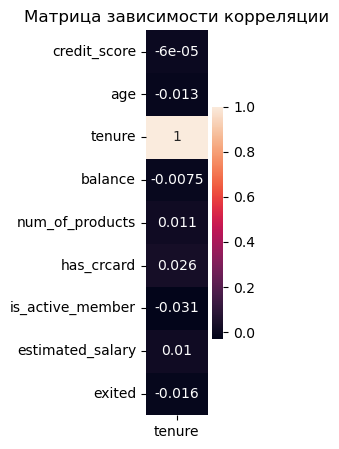

In [21]:
plt.figure(figsize=(1, 5))
plt.title('Матрица зависимости корреляции')

sns.heatmap(df_filled1.corr()[['tenure']], annot = True)

plt.show()


**Значения коэффициента Пирсона значительно не изменились, можно заменить датасет на новый:**

In [22]:
df = df_filled

**Прежде, чем обучать модель, подготовим данные для обработки:**
* Применим стандартизацию и OHE, чтобы применить несколько моделей машинного обучения (и не создавать множество датасетов).

In [23]:
df = pd.get_dummies(df, drop_first=True)
df.head(10)

,credit_score,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False
5,645,44,8.0,113755.78,2,1,0,149756.71,1,False,True,True
6,822,50,7.0,0.00,2,1,1,10062.80,0,False,False,True
7,376,29,4.0,115046.74,4,1,0,119346.88,1,True,False,False
8,501,44,4.0,142051.07,2,0,1,74940.50,0,False,False,True
9,684,27,2.0,134603.88,1,1,1,71725.73,0,False,False,True


**Прежде, чем масштабировать признаки, необходимо разделить выборки на тестовую, валидационную и тренировочную, и обучить на этих данных стандартизацию:**

In [24]:
features = df.drop('exited', axis=1)
target = df['exited']

**Разделим выборки:**
* По ранее полученным графикам видно, что количество людей сильно отличается, значит, воспользуемся стратификацией, для более точных предсказаний
* Какую часть данных отвести под валидационную выборку, решают в зависимости от количества объектов, признаков и вариативности данных. 
* Вот два самых распространённых сценария:
  * Доступен исходный датасет, а тестовая выборка спрятана. Тогда рекомендуется **75%** данных отвести под обучающую, а **25%** — под валидационную. Соотношение **3:1**.
  * Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении **3:1:1**. Воспользуемся вторым методом, так как тестовой выборки нет.

In [25]:
# воспользуемся train_test_split с стратификацией по target
df_f_train, df_f_test, df_t_train, df_t_test = train_test_split(features,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=12345, 
                                                                stratify=target)
# воспользуемся train_test_split с стратификацией по target

df_f_train, df_f_valid, df_t_train, df_t_valid = train_test_split(df_f_train,
                                                                df_t_train,
                                                                test_size=0.25,
                                                                random_state=12345, 
                                                                stratify=df_t_train)

In [26]:
# выведем размеры получившихся выборок
print('Размеры выборок:')
print('df_f_train: ', df_f_train.shape)
print('df_f_valid: ', df_f_valid.shape)
print('df_f_test:  ', df_f_test.shape)

Размеры выборок:
df_f_train:  (6000, 11)
df_f_valid:  (2000, 11)
df_f_test:   (2000, 11)


**Стандартизуем параметры:**

In [27]:
# необходимые параметры для стандартизации
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# обучаем стандартизацию
scaler = StandardScaler()
scaler.fit(df_f_train[numeric]) 
df_f_train[numeric] = scaler.transform(df_f_train[numeric])
df_f_valid[numeric] = scaler.transform(df_f_valid[numeric])

### Вывод

* Датасет состоит из 10000 строк, часть пропущенных значений заполнена.
* Выборка несбалансирована, примерно только **20%** клиентов уходят из банка.
* Данные предобратоны, заполнены пропущенные значения и предварительно обучена модель для стандартизации данных и дальнейшего обучения модели, приступим к исследованию моделей машинного обучения:

# 2. Исследование задачи

**Обучим модель без учёта дисбаланса.**

Прежде, чем обучать модель, создадим функцию, которая создаёт кривую и выводит значение **`AUC-ROC`**

In [28]:
# создаём функцию с построением графика AUC-ROC и расчета площади под кривой

def roc_auc_fig(model, features_valid=df_f_valid, target_valid=df_t_valid):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('Площадь под кривой ROC: {:.4f}'.format(roc_auc_score(target_valid, probabilities_one_valid)))
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

* Для машинного обучения на тренировочной выборке воспользуемся ранее изученными способами классификации:
  * Дерево решений
  * Случайный лес
  * Логистическая регрессия
  * Так же подберём гиперпараметры на валидацонной выборке.



## 2.1 Дерево решений

Рассмотрим одну популярную модель — решающее дерево. Оно может описывать процесс принятия решения почти в любой ситуации. На основе значений признаков формулируются ответы, а затем выстраивается дерево с ответами «Да»/«Нет» и различными вариантами действий:

**Сразу подберём лучшие параметры для несбалансированной выборки:**

In [29]:
best_depth_t = 0
f1_best_t = 0

for depth in tqdm(range(2, 20)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(df_f_train, df_t_train)
    predictions_valid = model.predict(df_f_valid)
    f1 = f1_score(df_t_valid, predictions_valid)
    if f1 > f1_best_t:
        best_depth_t = depth
        f1_best_t = f1
        
# сохраним лучшие параметры в словаре
tree_best = {'depth':best_depth_t}

100%|██████████| 18/18 [00:00<00:00, 25.05it/s]


* Модель обучена, лучше параметры сохранены, проверим метрики качества:

In [30]:
model = DecisionTreeClassifier(random_state=12345,
                               max_depth=best_depth_t)
model.fit(df_f_train, df_t_train)
predictions_valid = model.predict(df_f_valid)
report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.880632,0.944758,0.911569,1593.000
exited,0.697595,0.498771,0.581662,407.000
accuracy,0.854000,0.854000,0.854000,0.854
macro avg,0.789113,0.721765,0.746615,2000.000
weighted avg,0.843384,0.854000,0.844433,2000.000


Площадь под кривой ROC: 0.8097


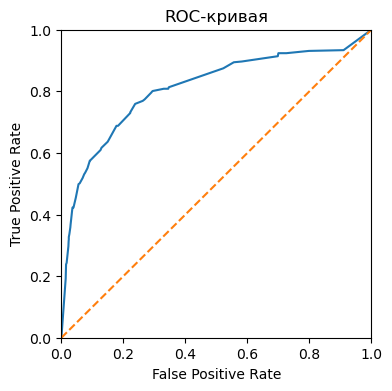

In [31]:
roc_auc_fig(model)

**Вывод:**
* Значения **`F1`**-меры меньше, чем **0.59** - **0.581662**
* Площадь под кривой **`ROC`** - **0.8097**
* **Метрики качества не соответствуют необходимому условию.**

## 2.2 Случайный лес

Один из алгоритмов классификации — случайный лес (random forest). 
Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования.

**Сразу подберём лучшие параметры для несбалансированной выборки:**

In [32]:
best_depth_f = 0
best_est_f = 0
f1_best_f = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range (2, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(df_f_train, df_t_train)
        predictions_valid = model.predict(df_f_valid)
        f1 = f1_score(df_t_valid, predictions_valid)
        if f1 > f1_best_f:
            best_depth_f = depth
            best_est_f = est
            f1_best_f = f1
            
# сохраняем параметры в словаре
forest_best = {'depth':best_depth_f, 'n_estimators':best_est_f}

100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


In [33]:
model = RandomForestClassifier(random_state=12345,
                               n_estimators=best_est_f,
                               max_depth=best_depth_f)
model.fit(df_f_train, df_t_train)
predictions_valid = model.predict(df_f_valid)
report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.869905,0.978029,0.920804,1593.000
exited,0.832536,0.427518,0.564935,407.000
accuracy,0.866000,0.866000,0.866000,0.866
macro avg,0.851220,0.702774,0.742869,2000.000
weighted avg,0.862300,0.866000,0.848384,2000.000


Площадь под кривой ROC: 0.8659


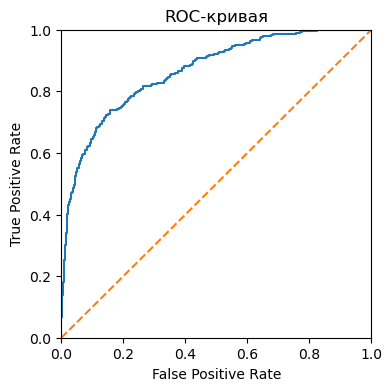

In [34]:
roc_auc_fig(model)

**Вывод:**
* Значения **`F1`**-меры меньше, чем **0.59** - **0.564935**
* Площадь под кривой **`ROC`** - **0.8659**
* **Метрики качества не соответствуют необходимому условию.**

## 2.3 Логистическая регрессия

Ещё один алгоритм машинного обучения — логистическая регрессия.

Если название и «мимикрирует» под задачу регрессии, всё-таки это алгоритм классификации. Логистическая регрессия:

Сначала считает, к какому классу близок объект
* В зависимости от ответа выбирает нужный класс: если результат вычисления положительный, то — «1»; отрицательный — «0».
* В логистической регрессии параметров мало. Что-либо вызубрить по признакам в формуле не выйдет, поэтому и вероятность переобучения невелика.

**Проверим модель:**

In [35]:
model = LogisticRegression(random_state=12345)
model.fit(df_f_train, df_t_train)
predictions_valid = model.predict(df_f_valid)

report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report


,precision,recall,f1-score,support
Non-exited,0.828526,0.973635,0.895238,1593.0000
exited,0.671875,0.211302,0.321495,407.0000
accuracy,0.818500,0.818500,0.818500,0.8185
macro avg,0.750200,0.592468,0.608367,2000.0000
weighted avg,0.796647,0.818500,0.778481,2000.0000


Площадь под кривой ROC: 0.7876


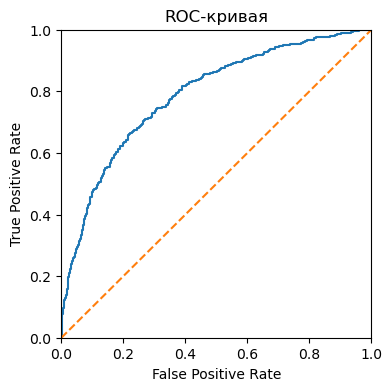

In [36]:
roc_auc_fig(model)

**Вывод:**
* Значения **`F1`**-меры меньше, чем **0.59** - **0.321495**
* Площадь под кривой **`ROC`** - **0.7876**
* **Метрики качества не соответствуют необходимому условию.**

**Создадим таблицу и посмотрим значения метрик F1-меры:**

In [37]:
f1_lgr = report.loc['exited', 'f1-score']
f1_lgr

models = ['tree', 'forest', 'lgr']
f1_scores = [f1_best_t, f1_best_f, f1_lgr]

best_param_model = pd.DataFrame({'model':models, 'f1_score':f1_scores})
best_param_model

,model,f1_score
0,tree,0.581662
1,forest,0.564935
2,lgr,0.321495


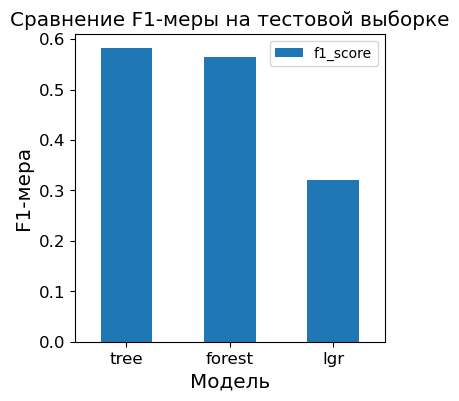

In [38]:
best_param_model.plot.bar(x='model', figsize=(4,4), rot=0, fontsize='large')
plt.title('Сравнение F1-меры на тестовой выборке', fontsize='x-large')
plt.xlabel('Модель', fontsize='x-large')
plt.ylabel('F1-мера', fontsize='x-large')
plt.show()

### Вывод

* Самые лучшие значения метрик на несбалансированной выборке получились у модели случайного леса:
  * **`F1`**-мера - **0.564935**
  * Площадь под кривой **`ROC`** - **0.8659**
* **Но значение **`F1`**-меры меньше, чем **0.59**, соответсвенно, нужно провести борьбу с дисбалансом.**

# 3.Борьба с дисбалансом

**Проведем борьбу с дисбалансом классов с помощью нескольких популярных способов:**
* Увеличение выборки
* Уменьшение выборки
* Взвешивание классов
* Изменение порога классификации

## Увеличение выборки

Для улучшения качества модели, увеличим обучающую выборку, обучим модель и проверим полученные метрики:

In [39]:
# Создаём функцию, которая увеличивает обучающую выборку и перемешивает ее

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Увеличим выборку в 4 раза, так как 20% клиентов уходят из банка (чтобы значения были приблизительно равны):

In [40]:
df_f_upsampled, df_t_upsampled = upsample(df_f_train, df_t_train, 4)

**Дерево решений**

Проверим качество модели на увеличенной обучающей выборке:

In [41]:
best_depth_t = 0
f1_best_t = 0

for depth in tqdm(range(2, 20)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(df_f_upsampled, df_t_upsampled)
    predictions_valid = model.predict(df_f_valid)
    f1 = f1_score(df_t_valid, predictions_valid)
    if f1 > f1_best_t:
        best_depth_t = depth
        f1_best_t = f1

100%|██████████| 18/18 [00:01<00:00, 14.49it/s]


In [42]:
model = DecisionTreeClassifier(random_state=12345,
                               max_depth=best_depth_t)
model.fit(df_f_upsampled, df_t_upsampled)
predictions_valid = model.predict(df_f_valid)
report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.934109,0.756434,0.835935,1593.0000
exited,0.453521,0.791155,0.576544,407.0000
accuracy,0.763500,0.763500,0.763500,0.7635
macro avg,0.693815,0.773795,0.706240,2000.0000
weighted avg,0.836309,0.763500,0.783149,2000.0000


Площадь под кривой ROC: 0.8364


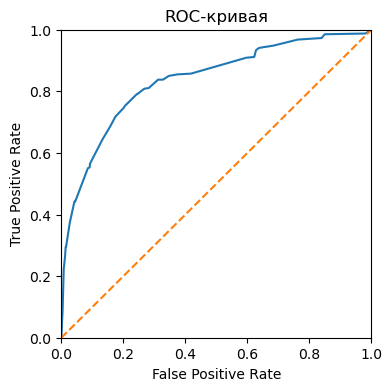

In [43]:
roc_auc_fig(model)

**Вывод:**
​
*  Значения F1-меры меньше, чем 0.59 - **0.576544**
*  Площадь под кривой ROC - **0.8364**
​
Метрики качества не соответствуют необходимому условию, но метрики увеличились.

**Случаный лес**

Проверим качество модели на увеличенной обучающей выборке:

In [44]:
best_depth_f = 0
best_est_f = 0
f1_best_f = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range (2, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(df_f_upsampled, df_t_upsampled)
        predictions_valid = model.predict(df_f_valid)
        f1 = f1_score(df_t_valid, predictions_valid)
        if f1 > f1_best_f:
            best_depth_f = depth
            best_est_f = est
            f1_best_f = f1

100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


In [45]:
model = RandomForestClassifier(random_state=12345,
                               n_estimators=best_est_f,
                               max_depth=best_depth_f)
model.fit(df_f_upsampled, df_t_upsampled)
predictions_valid = model.predict(df_f_valid)
report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.927148,0.846830,0.885171,1593.000
exited,0.552294,0.739558,0.632353,407.000
accuracy,0.825000,0.825000,0.825000,0.825
macro avg,0.739721,0.793194,0.758762,2000.000
weighted avg,0.850865,0.825000,0.833722,2000.000


Площадь под кривой ROC: 0.8679


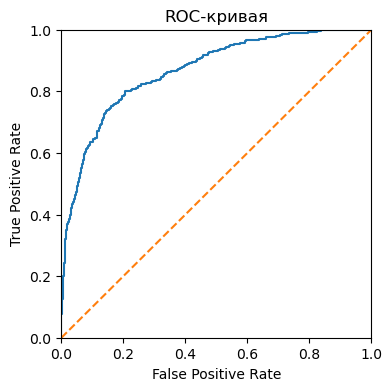

In [46]:
roc_auc_fig(model)

**Вывод:**

*  Значения F1-меры стало больше, чем 0.59 - **0.632353**
*  Площадь под кривой ROC - **0.8679**

Метрики качества  соответствуют необходимому условию, такую модель можно использовать дальше.

**Логистическая регрессия**

Проверим качество модели на увеличенной обучающей выборке:

In [47]:
model = LogisticRegression(random_state=12345)
model.fit(df_f_upsampled, df_t_upsampled)
predictions_valid = model.predict(df_f_valid)

report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.910484,0.708726,0.797035,1593.0000
exited,0.389474,0.727273,0.507284,407.0000
accuracy,0.712500,0.712500,0.712500,0.7125
macro avg,0.649979,0.717999,0.652159,2000.0000
weighted avg,0.804458,0.712500,0.738071,2000.0000


Площадь под кривой ROC: 0.7919


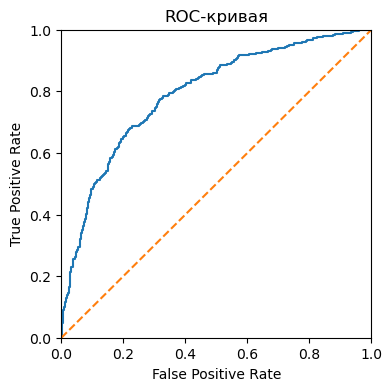

In [48]:
roc_auc_fig(model)

**Вывод:**

*  Значения F1-меры меньше, чем 0.59 - **0.507284**
*  Площадь под кривой ROC - **0.7919**

Метрики качества не соответствуют необходимому условию, но увеличились.

**Вывод**

По 2-м моделям машинного обучения необходимое качество модели не достигнуто.

Только модель случайного леса смогла достичь метрики F1-меры до необходимых значений, проверим дальнейшие способы борьбы с несбалансированными классами

## Уменьшение выборки

Для улучшения качества модели, уменьшим обучающую выборку, обучим модель и проверим полученные метрики:

In [49]:
# Создаём функцию, которая уменьшает обучающую выборку и перемешивает ее

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Уменьшаем выборку в 4 раза, так как 20% клиентов уходят из банка (чтобы значения были приблизительно равны):

In [50]:
df_f_downsampled, df_t_downsampled = downsample(df_f_train, df_t_train, 0.25)

**Дерево решений**

Проверим качество модели на уменьшенной обучающей выборке:

In [51]:
best_depth_t = 0
f1_best_t = 0

for depth in tqdm(range(2, 20)):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(df_f_downsampled, df_t_downsampled)
    predictions_valid = model.predict(df_f_valid)
    f1 = f1_score(df_t_valid, predictions_valid)
    if f1 > f1_best_t:
        best_depth_t = depth
        f1_best_t = f1

100%|██████████| 18/18 [00:00<00:00, 31.15it/s]


In [52]:
model = DecisionTreeClassifier(random_state=12345,
                               max_depth=best_depth_t)
model.fit(df_f_downsampled, df_t_downsampled)
predictions_valid = model.predict(df_f_valid)
report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.920198,0.817954,0.866068,1593.0000
exited,0.503425,0.722359,0.593340,407.0000
accuracy,0.798500,0.798500,0.798500,0.7985
macro avg,0.711811,0.770156,0.729704,2000.0000
weighted avg,0.835384,0.798500,0.810568,2000.0000


Площадь под кривой ROC: 0.8435


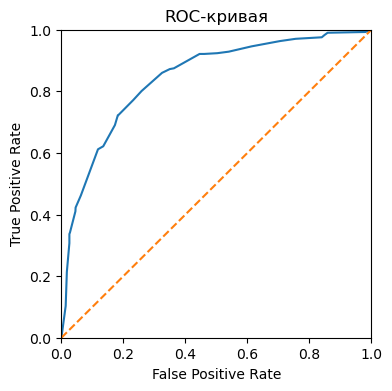

In [53]:
roc_auc_fig(model)

**Вывод:**

* Значения F1-меры чуть больше, чем 0.59 - **0.593340**
* Площадь под кривой ROC - **0.8435**

Метрики качества соответствуют необходимому условию, но метрики увеличились незначительно.

**Случаный лес**

Проверим качество модели на уменьшенной обучающей выборке:

In [54]:
best_depth_f = 0
best_est_f = 0
f1_best_f = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range (2, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(df_f_downsampled, df_t_downsampled)
        predictions_valid = model.predict(df_f_valid)
        f1 = f1_score(df_t_valid, predictions_valid)
        if f1 > f1_best_f:
            best_depth_f = depth
            best_est_f = est
            f1_best_f = f1

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


In [55]:
model = RandomForestClassifier(random_state=12345,
                               n_estimators=best_est_f,
                               max_depth=best_depth_f)
model.fit(df_f_downsampled, df_t_downsampled)
predictions_valid = model.predict(df_f_valid)
report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.931408,0.809793,0.866353,1593.000
exited,0.507317,0.766585,0.610568,407.000
accuracy,0.801000,0.801000,0.801000,0.801
macro avg,0.719363,0.788189,0.738460,2000.000
weighted avg,0.845105,0.801000,0.814301,2000.000


Площадь под кривой ROC: 0.8722


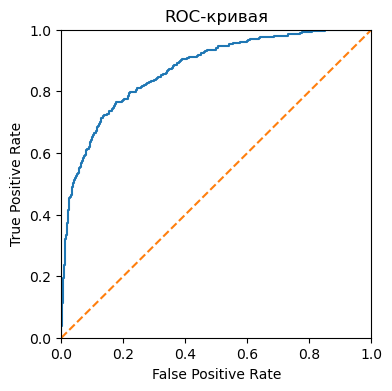

In [56]:
roc_auc_fig(model)

**Вывод:**

* Значения F1-меры больше, чем 0.59 - **0.610568**
* Площадь под кривой ROC - **0.8722**

Метрики качества соответствуют необходимому условию, такой способ можно использовать для увеличения качества модели.

**Логистическая регрессия**

Проверим качество модели на уменьшенной обучающей выборке:

In [57]:
model = LogisticRegression(random_state=12345)
model.fit(df_f_downsampled, df_t_downsampled)
predictions_valid = model.predict(df_f_valid)

report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.908944,0.708098,0.796048,1593.000
exited,0.387352,0.722359,0.504288,407.000
accuracy,0.711000,0.711000,0.711000,0.711
macro avg,0.648148,0.715228,0.650168,2000.000
weighted avg,0.802800,0.711000,0.736675,2000.000


Площадь под кривой ROC: 0.7913


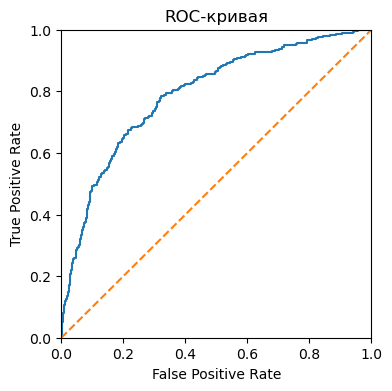

In [58]:
roc_auc_fig(model)

**Вывод:**

* Значения F1-меры меньше, чем 0.59 - **0.504288**
* Площадь под кривой ROC - **0.7913**

Метрики качества не соответствуют необходимому условию, но метрики увеличились.

**Вывод**

По 1-ой модели машинного обучения необходимое качество модели не достигнуто.

Модель дерева решений и случайного леса смогли достичь метрики F1-меры до необходимых значений, причем модель случайного леса показала большее значение. Проверим другие способы борьбы.

## Взвешивание классов

Проверим параметр **class_weight** на логистической регрессии:

In [59]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(df_f_train, df_t_train)
predictions_valid = model.predict(df_f_valid)

report = classification_report(df_t_valid, predictions_valid, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.910103,0.718142,0.802807,1593.000
exited,0.395693,0.722359,0.511304,407.000
accuracy,0.719000,0.719000,0.719000,0.719
macro avg,0.652898,0.720250,0.657056,2000.000
weighted avg,0.805421,0.719000,0.743486,2000.000


Площадь под кривой ROC: 0.7918


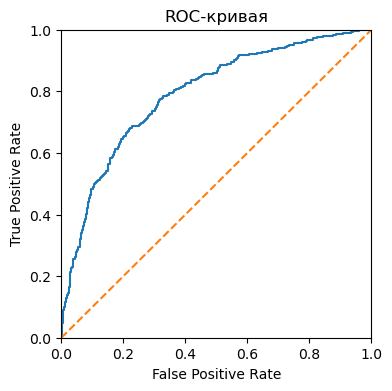

In [60]:
roc_auc_fig(model)

**Вывод:**

* Значения F1-меры меньше, чем 0.59 - **0.511304**
* Площадь под кривой ROC - **0.7918**

Метрики качества не соответствуют необходимому условию, хотя и увеличились, по сравнению с предыдущим исследованием.

## Изменение порога

Чтобы определить ответ: модель вычисляет, к какому классу близок объект, затем сравнивает результат с нулём. Для удобства близость к классам переведём в вероятность классов: модель пытается оценить, насколько вероятен тот или иной класс. У нас всего два класса (ноль и единица). Нам достаточно вероятности класса «1». Число будет от нуля до единицы: если больше 0.5 — объект положительный, меньше — отрицательный.

Поменяем значения вероятности класса и проверим, как это повлияет на метрики качества моделей:

**Дерево решений**

Проверим качество модели на подборе порога значений классификации:

In [61]:
model = DecisionTreeClassifier(random_state=12345, max_depth=tree_best['depth'])
model.fit(df_f_train, df_t_train)
probabilities_valid = model.predict_proba(df_f_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
predicted_best = []
for threshold in np.arange(0, 1.1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(df_t_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid

In [62]:
report = classification_report(df_t_valid, predicted_best, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.893210,0.908349,0.900716,1593.0000
exited,0.615789,0.574939,0.594663,407.0000
accuracy,0.840500,0.840500,0.840500,0.8405
macro avg,0.754500,0.741644,0.747690,2000.0000
weighted avg,0.836755,0.840500,0.838434,2000.0000


Площадь под кривой ROC: 0.8097


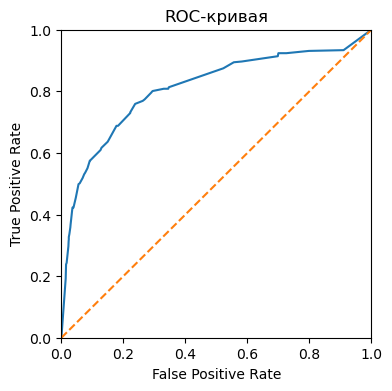

In [63]:
roc_auc_fig(model)

**Вывод:**

* Значения F1-меры чуть больше, чем 0.59 - **0.594663**
* Площадь под кривой ROC - **0.8097**

Метрики качества соответствуют необходимому условию, но метрики увеличились незначительно.

**Случайный лес**

Проверим качество модели на подборе порога значений классификации:

In [64]:
model = RandomForestClassifier(random_state=12345, 
                               max_depth=forest_best['depth'], 
                               n_estimators=forest_best['n_estimators'])
model.fit(df_f_train, df_t_train)
probabilities_valid = model.predict_proba(df_f_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
for threshold in np.arange(0, 1.1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(df_t_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid

In [65]:
report = classification_report(df_t_valid, predicted_best, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.913015,0.889517,0.901113,1593.0000
exited,0.607143,0.668305,0.636257,407.0000
accuracy,0.844500,0.844500,0.844500,0.8445
macro avg,0.760079,0.778911,0.768685,2000.0000
weighted avg,0.850770,0.844500,0.847215,2000.0000


Площадь под кривой ROC: 0.8659


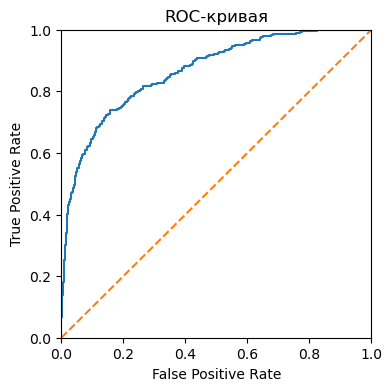

In [66]:
roc_auc_fig(model)

**Вывод:**

* Значения F1-меры стало больше, чем 0.59 - **0.636257**
* Площадь под кривой ROC - **0.8659**

Метрики качества соответствуют необходимому условию, такую модель можно использовать дальше.

**Логистическая регрессия**

In [67]:
model = LogisticRegression(random_state=12345)
model.fit(df_f_train, df_t_train)
probabilities_valid = model.predict_proba(df_f_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
for threshold in np.arange(0, 1.1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(df_t_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid

In [68]:
report = classification_report(df_t_valid, predicted_best, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.900145,0.780917,0.836303,1593.0000
exited,0.435275,0.660934,0.524878,407.0000
accuracy,0.756500,0.756500,0.756500,0.7565
macro avg,0.667710,0.720925,0.680590,2000.0000
weighted avg,0.805544,0.756500,0.772928,2000.0000


Площадь под кривой ROC: 0.7876


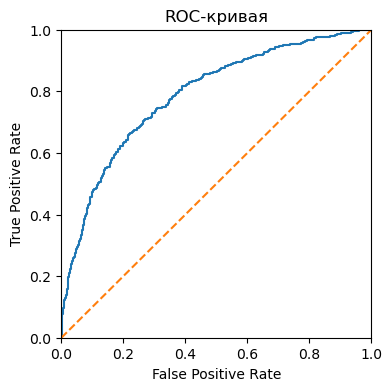

In [69]:
roc_auc_fig(model)

**Вывод:**

* Значения F1-меры меньше, чем 0.59 - **0.524878**
* Площадь под кривой ROC - **0.7876**
Метрики качества не соответствуют необходимому условию, но метрики увеличились.

**Вывод:**

По 1-ой модели машинного обучения необходимое качество модели не достигнуто.

Модель дерева решений и случайного леса смогли достичь метрики F1-меры до необходимых значений, причем модель случайного леса показала большее значение. Воспользуемся моделью случайного леса.

## Объединение способов

Для дальнейшего тестирования модели, попробуем объединить два способа борьбы с дисбалансом, которые выдали наибольшие значения метрик F1-меры:

1. Увеличение выборки
2. Подбор вероятности порога классификации

Проверим качество модели при объединении двух способов. Если метрика будет выше - можно тестировать модель.

In [70]:
# подбираем гиперпараметры на увеличенной выборке

best_depth_f = 0
best_est_f = 0
f1_best_f = 0

for est in tqdm(range(10, 51, 10)):
    for depth in range (2, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(df_f_upsampled, df_t_upsampled)
        predictions_valid = model.predict(df_f_valid)
        f1 = f1_score(df_t_valid, predictions_valid)
        if f1 > f1_best_f:
            best_depth_f = depth
            best_est_f = est
            f1_best_f = f1

100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


In [71]:
# подбираем порог классификации для обученной модели

model = RandomForestClassifier(random_state=12345,
                               n_estimators=best_est_f,
                               max_depth=best_depth_f)
model.fit(df_f_upsampled, df_t_upsampled)
probabilities_valid = model.predict_proba(df_f_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_best = 0
for threshold in np.arange(0, 1.1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(df_t_valid, predicted_valid)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted_valid

In [72]:
report = classification_report(df_t_valid, predicted_best, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.923387,0.862524,0.891918,1593.0000
exited,0.572266,0.719902,0.637650,407.0000
accuracy,0.833500,0.833500,0.833500,0.8335
macro avg,0.747826,0.791213,0.764784,2000.0000
weighted avg,0.851934,0.833500,0.840175,2000.0000


Площадь под кривой ROC: 0.8679


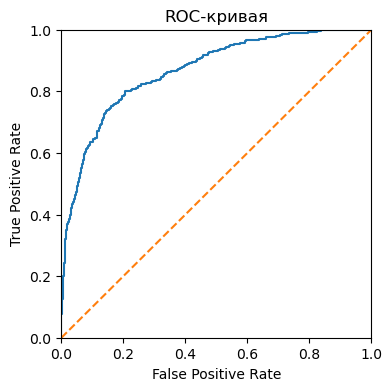

In [73]:
roc_auc_fig(model)

**Вывод:**

Метрики модели выросли:

* Значения F1-меры больше, чем **0.59** и больше полученных ранее способов - **0.637650**
* Площадь под кривой ROC - **0.8679**

Данный способ можно тестировать.

## Тестирование модели

Проведем тестирование модели на тестовой выборке с помощью:

1. Модели случайного леса
2. Увеличения выборки
3. Подбора порога классификации

Так как данный способ показал наивысшую метрику качества F1-меры - **0.637650**

Прежде, чем проверять метрики лучшей модели и способа борьбы с дисбалансом, необходимо:

* стандартизировать данные в тестовой выборке с помощью ранее обученной модели стандартизации
* объединить обучающую и валидационную выборку и увеличить 

In [74]:
# стандартизируем
df_f_test[numeric] = scaler.transform(df_f_test[numeric])

In [75]:
# объединяем финальные обучающие выборки
final_f = pd.concat([df_f_train, df_f_valid])
final_t = pd.concat([df_t_train, df_t_valid])

Проверим дисбаланс классов:

In [76]:
display(final_t.sum(), final_t.count())

1630

8000

Разница чуть меньше, чем в 5 раз.

Увеличим выборку примерно в 4 раза и посмотрим результат.

In [77]:
# увеличиваем выборку
final_f, final_t = upsample(final_f, final_t, 4)

In [78]:
model = RandomForestClassifier(random_state=12345,
                               n_estimators=best_est_f,
                               max_depth=best_depth_f)
model.fit(final_f, final_t)
probabilities = model.predict_proba(df_f_test)
probabilities_one = probabilities[:, 1]

predicted_best = []
f1_best = 0
for threshold in np.arange(0, 1.1, 0.02):
    predicted = probabilities_one > threshold
    f1 = f1_score(df_t_test, predicted)
    if f1 > f1_best:
        f1_best = f1
        predicted_best = predicted

In [79]:
report = classification_report(df_t_test, predicted_best, target_names=['Non-exited', 'exited'], output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
Non-exited,0.918758,0.873195,0.895397,1593.0000
exited,0.584362,0.697789,0.636058,407.0000
accuracy,0.837500,0.837500,0.837500,0.8375
macro avg,0.751560,0.785492,0.765728,2000.0000
weighted avg,0.850709,0.837500,0.842622,2000.0000


Площадь под кривой ROC: 0.8617


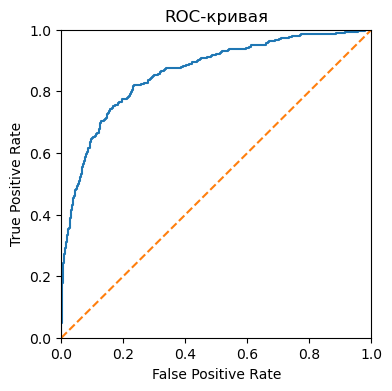

In [80]:
roc_auc_fig(model, df_f_test, df_t_test)

**Вывод:**

* Значения F1-меры - **0.636058**
* Площадь под кривой ROC - **0.8617**

Необходимые метрики достигнуты.

# Общий вывод

Для полученных данных, чтобы получить наибольшие и необходимые значения F1-меры, необходимо использовать:

1. Модель случайного леса
2. Увеличение обучающей выборки
3. Подбор порога вероятности положительного класса

В таком случае метрики на протестированной модели получили данные значения:

* F1-мера - **0.636058**
* Площадь под кривой ROC - **0.8617**
* Полнота - **0.697789**
* Точность - **0.584362**